<a href="https://colab.research.google.com/github/hnt4499/Facial-Keypoint-Detection/blob/master/Facial_Keypoints_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio Shapely
!pip install imgaug


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Activation, BatchNormalization,\
Add, Input, ZeroPadding2D, AveragePooling2D, GlobalMaxPooling2D, Dropout
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.initializers import glorot_uniform

Using TensorFlow backend.


In [0]:
train = pd.read_csv("/content/drive/My Drive/ML/Kaggle/3. Facial Keypoints Detection/training.csv")
test = pd.read_csv("/content/drive/My Drive/ML/Kaggle/3. Facial Keypoints Detection/test.csv")

In [0]:
train.shape

(7049, 31)

In [0]:
train.isnull().any().value_counts()

True     28
False     3
dtype: int64

In [0]:
train.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

In [0]:
X_train = []
for i in range(train.shape[0]):
  X_train.append(train["Image"][i].split())

In [0]:
X_train = np.array(X_train, dtype = 'int')
X_train = X_train.reshape(-1, 96, 96, 1)

In [0]:
X_train.shape

(7049, 96, 96, 1)

In [0]:
train[train["left_eye_center_x"].isnull()].head(2)


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
1687,NaN,NaN,NaN,NaN,57.931068,40.808627,73.232712,44.910035,NaN,NaN,...,55.500993,54.595918,74.511943,24.118659,68.652754,39.136317,71.487238,37.405514,75.520178,53 55 55 56 57 58 60 62 63 64 65 66 69 71 72 6...
1834,NaN,NaN,NaN,NaN,41.122383,43.111925,49.822688,39.401949,28.818827,47.168082,...,63.240190,54.380973,63.966847,31.776519,74.325852,37.135567,70.228468,41.736649,76.507387,68 68 69 68 68 70 67 68 73 70 70 70 71 70 69 7...


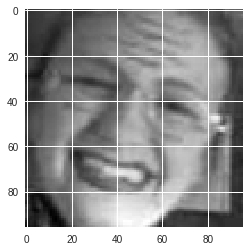

In [0]:
# Show the image indexed 1687 to see what happened
plt.imshow(X_train[1687], cmap = 'gray')
plt.show()

**Replace missing values with zeros**

In [0]:
def rep_zeros(train):
  Y_train = train.fillna(value = 0)
  return np.array(Y_train.iloc[:, :30])

**Replace missing values with its previous value.**

In [0]:
def rep_pre(train):
  Y_train = train.fillna(method = 'ffill', axis = 0)
  return np.array(Y_train.iloc[:, :30])

**Generate test images**

In [0]:
X_test = []
for i in range(test.shape[0]):
  X_test.append(test["Image"][i].split())

In [0]:
X_test = np.array(X_test, dtype = "int")
X_test = X_test.reshape(-1, 96, 96, 1)
X_test.shape

(1783, 96, 96, 1)

**Learning rate decay**

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_absolute_error', patience=10, verbose=1, \
                                            factor=0.8, min_lr=0.00001)

# Data Visualization

In [0]:
def vis(history, zoom = False):
  legend = []
  for i, j in enumerate(history):
    plt.plot(j.history['acc'])
    plt.plot(j.history['val_acc'])
    t = ["Model {} train".format(i + 1), "Model {} val".format(i + 1)]
    legend.extend(t)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(legend, loc='lower right')
  if zoom:
    plt.axis([0, 30, 0.97, 1])
  plt.show()
  
  # summarize history for loss
  legend = []
  for i, j in enumerate(history):
    plt.plot(j.history['loss'])
    plt.plot(j.history['val_loss'])
    t = ["Model {} train".format(i + 1), "Model {} val".format(i + 1)]
    legend.extend(t)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')
  if zoom:
    plt.axis([0, 30, 0, 0.25])
  plt.show()

# AlexNet Implementation

In [0]:
def AlexNet():
  np.random.seed(4444)
  
  model = Sequential()
  
  model.add(Conv2D(filters = 64, input_shape = (96, 96, 1), kernel_size = (7, 7), strides = (1, 1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
  
  model.add(Conv2D(filters = 128, kernel_size = (5, 5), strides = (1, 1), padding = 'same', kernel_initializer = glorot_uniform(seed=0)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'valid'))
  
  model.add(Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = glorot_uniform(seed=0)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
  
  model.add(Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = glorot_uniform(seed=0)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'valid'))
  
  model.add(Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = glorot_uniform(seed=0)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'valid'))
  
  model.add(Flatten())
  
  model.add(Dense(units = 2048, activation = 'relu', kernel_regularizer = 'l2', kernel_initializer = glorot_uniform(seed=0)))
  
  model.add(Dense(units = 1024, activation = 'relu', kernel_regularizer = 'l2', kernel_initializer = glorot_uniform(seed=0)))
    
  model.add(Dense(units = 30, kernel_regularizer = 'l2', kernel_initializer = glorot_uniform(seed=0)))
  
  model.summary()
  
  model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mae', 'acc'])
  
  return model

# Model Assessment: AlexNet

In [0]:
epochs = 30
batch_size = 100

In [0]:
checkpoint = ModelCheckpoint("/content/drive/My Drive/ML/Kaggle/3. Facial Keypoints Detection/alex_1.h5", \
                             monitor="val_mean_absolute_error", verbose=1, save_best_only=True, mode='min')

***With method of replacing missing values with 0***

In [0]:
Y_train = rep_pre(train)

In [0]:
model = AlexNet()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 90, 90, 64)        3200      
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 90, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 90, 90, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 45, 45, 128)       512       
_________________________________________________________________
acti

In [0]:
alex_1_history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, verbose = 2,\
                           callbacks = [learning_rate_reduction, checkpoint], validation_split = 0.1)

Instructions for updating:
Use tf.cast instead.
Train on 6344 samples, validate on 705 samples
Epoch 1/30
 - 20s - loss: 134.8514 - mean_absolute_error: 5.1882 - acc: 0.5115 - val_loss: 44.2966 - val_mean_absolute_error: 3.9055 - val_acc: 0.5986

Epoch 00001: val_mean_absolute_error improved from inf to 3.90546, saving model to /content/drive/My Drive/ML/Kaggle/3. Facial Keypoints Detection/alex_1.h5
Epoch 2/30
 - 15s - loss: 28.4847 - mean_absolute_error: 2.0707 - acc: 0.6252 - val_loss: 39.0010 - val_mean_absolute_error: 3.7789 - val_acc: 0.5574

Epoch 00002: val_mean_absolute_error improved from 3.90546 to 3.77895, saving model to /content/drive/My Drive/ML/Kaggle/3. Facial Keypoints Detection/alex_1.h5
Epoch 3/30
 - 15s - loss: 26.1336 - mean_absolute_error: 2.0535 - acc: 0.6179 - val_loss: 24.4314 - val_mean_absolute_error: 2.0152 - val_acc: 0.5631

Epoch 00003: val_mean_absolute_error improved from 3.77895 to 2.01518, saving model to /content/drive/My Drive/ML/Kaggle/3. Facial Ke

 ***Load model***



In [0]:
model = load_model("/content/drive/My Drive/ML/Kaggle/3. Facial Keypoints Detection/alex_1.h5")

In [0]:
alex_1_history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = 200, verbose = 2,\
                           callbacks = [learning_rate_reduction, checkpoint], validation_split = 0.1)

Train on 6344 samples, validate on 705 samples
Epoch 1/200
 - 16s - loss: 7.0826 - mean_absolute_error: 0.9238 - acc: 0.8589 - val_loss: 8.8485 - val_mean_absolute_error: 1.1178 - val_acc: 0.7106

Epoch 00001: val_mean_absolute_error did not improve from 1.06866
Epoch 2/200
 - 15s - loss: 6.9332 - mean_absolute_error: 0.9253 - acc: 0.8578 - val_loss: 8.2283 - val_mean_absolute_error: 1.0693 - val_acc: 0.7376

Epoch 00002: val_mean_absolute_error did not improve from 1.06866
Epoch 3/200
 - 15s - loss: 6.7328 - mean_absolute_error: 0.8954 - acc: 0.8640 - val_loss: 9.9554 - val_mean_absolute_error: 1.3741 - val_acc: 0.7092

Epoch 00003: val_mean_absolute_error did not improve from 1.06866
Epoch 4/200
 - 15s - loss: 6.6132 - mean_absolute_error: 0.8968 - acc: 0.8689 - val_loss: 8.6232 - val_mean_absolute_error: 1.1646 - val_acc: 0.7035

Epoch 00004: val_mean_absolute_error did not improve from 1.06866
Epoch 5/200
 - 15s - loss: 6.4966 - mean_absolute_error: 0.9007 - acc: 0.8660 - val_loss:

*-> Visualize the model*

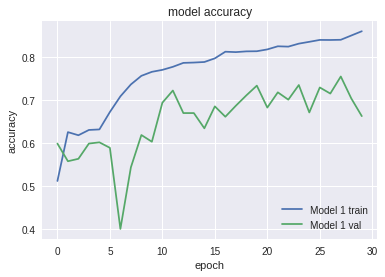

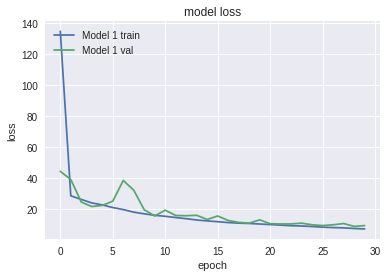

In [0]:
vis([alex_1_history])

***With method of replacing missing values with previous values***

In [0]:
Y_train = rep_pre(train)

In [0]:
model = AlexNet()
alex_2_history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, verbose = 2,\
                           callbacks = [learning_rate_reduction, checkpoint], validation_split = 0.1)

# ResNet Implementation

In [0]:
def identity_block(X, filters):
  X_shortcut = X
  
  X = Conv2D(filters = filters[0], kernel_size = (1, 1), strides = (1, 1), padding = 'valid',\
             kernel_initializer = glorot_uniform(seed = 0))(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  
  X = Conv2D(filters = filters[1], kernel_size = (3, 3), strides = (1, 1), padding = 'same',\
             kernel_initializer = glorot_uniform(seed = 0))(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  
  
  X = Conv2D(filters = filters[2], kernel_size = (1, 1), strides = (1, 1), padding = 'valid',\
             kernel_initializer = glorot_uniform(seed = 0))(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  
  
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)
  
  return X

In [0]:
def convolutional_block(X, filters, s):
  X_shortcut = X
  
  X = Conv2D(filters = filters[0], kernel_size = (1, 1), strides = (s, s), padding = 'valid',\
             kernel_initializer = glorot_uniform(seed = 0))(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  
  
  X = Conv2D(filters = filters[1], kernel_size = (3, 3), strides = (1, 1), padding = 'same',\
             kernel_initializer = glorot_uniform(seed = 0))(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  
  
  X = Conv2D(filters = filters[2], kernel_size = (1, 1), strides = (1, 1), padding = 'valid',\
             kernel_initializer = glorot_uniform(seed = 0))(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  
  
  X_shortcut = Conv2D(filters = filters[2], kernel_size = (1, 1), strides = (s, s), padding = 'valid',\
             kernel_initializer = glorot_uniform(seed = 0))(X_shortcut)
  X_shortcut = BatchNormalization()(X_shortcut)
  
  
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)
  
  return X

In [0]:
def ResNet50():
  X_input = Input((96, 96, 1))
  X = ZeroPadding2D((3, 3))(X_input)
  
  X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)
  
  X = convolutional_block(X, [64, 64, 256], s = 1)
  X = identity_block(X, [64, 64, 256])
  X = identity_block(X, [64, 64, 256])
  
  X = convolutional_block(X, [128, 128, 512], s = 2)
  X = identity_block(X, [128, 128, 512])
  X = identity_block(X, [128, 128, 512])
  X = identity_block(X, [128, 128, 512])
  
  X = convolutional_block(X, [256, 256, 1024], s = 2)
  X = identity_block(X, [256, 256, 1024])
  X = identity_block(X, [256, 256, 1024])
  X = identity_block(X, [256, 256, 1024])
  X = identity_block(X, [256, 256, 1024])
  X = identity_block(X, [256, 256, 1024])
  
  X = convolutional_block(X, [512, 512, 2048], s = 2)
  X = identity_block(X, [512, 512, 2048])
  X = identity_block(X, [512, 512, 2048])
  
  X = AveragePooling2D((2,2))(X)
  
  X = Flatten()(X)
  
  X = Dense(units = 1024, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
  X = Dropout(0.3)(X)
  
  X = Dense(units = 516, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
  X = Dropout(0.3)(X)
  
  X = Dense(units = 30, kernel_initializer = glorot_uniform(seed=0))(X)
  
  model = Model(inputs = X_input, outputs = X, name='ResNet50')
  
  model.summary()
  
  model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mae', 'acc'])
  
  return model
  

In [0]:
model = ResNet50()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1

In [0]:
checkpoint = ModelCheckpoint("/content/drive/My Drive/ML/Kaggle/3. Facial Keypoints Detection/resnet_1.h5", \
                             monitor="val_mean_absolute_error", verbose=1, save_best_only=True, mode='min')

In [0]:
restnet_1_history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = 200, verbose = 2,\
                           callbacks = [learning_rate_reduction, checkpoint], validation_split = 0.1)

Instructions for updating:
Use tf.cast instead.
Train on 6344 samples, validate on 705 samples
Epoch 1/200
 - 61s - loss: 203.8931 - mean_absolute_error: 10.0022 - acc: 0.2513 - val_loss: 110.8310 - val_mean_absolute_error: 6.0105 - val_acc: 0.4085

Epoch 00001: val_mean_absolute_error improved from inf to 6.01047, saving model to /content/drive/My Drive/ML/Kaggle/3. Facial Keypoints Detection/resnet_1.h5
Epoch 2/200
 - 44s - loss: 54.3083 - mean_absolute_error: 5.7609 - acc: 0.3323 - val_loss: 8.7183 - val_mean_absolute_error: 1.8666 - val_acc: 0.5986

Epoch 00002: val_mean_absolute_error improved from 6.01047 to 1.86663, saving model to /content/drive/My Drive/ML/Kaggle/3. Facial Keypoints Detection/resnet_1.h5
Epoch 3/200
 - 44s - loss: 41.9686 - mean_absolute_error: 5.0232 - acc: 0.3556 - val_loss: 6.5891 - val_mean_absolute_error: 1.4996 - val_acc: 0.5887

Epoch 00003: val_mean_absolute_error improved from 1.86663 to 1.49962, saving model to /content/drive/My Drive/ML/Kaggle/3. Fa

***Load model***

In [0]:
model = load_model("/content/drive/My Drive/ML/Kaggle/3. Facial Keypoints Detection/resnet_1.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


# Predict and Submit

In [0]:
predictions = model.predict(X_test)

In [0]:
lookup = pd.read_csv("/content/drive/My Drive/ML/Kaggle/3. Facial Keypoints Detection/IdLookupTable.csv")

In [0]:
ImageId = lookup.ImageId
FeatureName = lookup.FeatureName
RowId = lookup.RowId

In [0]:
cols = train.columns[:-1].values

In [0]:
predictions = pd.DataFrame(predictions, columns=cols)

In [0]:
predictions.shape

(1783, 30)

In [0]:
submit = []
for rowId, irow, landmark in zip(RowId, ImageId, FeatureName):
        submit.append([rowId, predictions[landmark].iloc[irow-1]])

In [0]:
submit = pd.DataFrame(submit,columns=["RowId","Location"])

In [0]:
submit.to_csv("/content/drive/My Drive/ML/Kaggle/3. Facial Keypoints Detection/resnet_1_submission.csv", index=False)